# Исследование надежности заемщиков

In [1]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Импортируем бибтотеку и прочитаем данные файла
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [3]:
#Посмотрим на первые десять строк датафрейма
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
#Изучим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В нашем датасете 21525 строк. Он раскрывает информацию о кредитных клиентах: количество детей, рабочий стаж, возраст, образование, семейный статус, средний заработок и цель кредита. Типы данных: int64, float64, object. 

Уже можно видеть пропуски в столбцах стажа, зарплаты. А также минусовые значение в столбце "стаж" - это мы исправим. А также проверим данные на дубликаты, выбросы и пропуски.

## Предобрадотка данных

### Удаление пропусков и дубликатов

In [5]:
#Проверим базу на пропуски
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Один из столбцов с пропущенными значениями — total_income — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца income_type. Например, у человека с типом занятости сотрудник пропуск в столбце total_income должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [6]:
#Заполним пропуски в столбце total_income медиативным значением
for t in data:
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

In [7]:
#Также заполним пропуски в столбце days_employed медиативным значением. 
#Перед этим посмотри на медиативные значения для каждого типа занятости
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете           -3296.759962
госслужащий         -2689.368353
компаньон           -1547.382223
пенсионер          365213.306266
предприниматель      -520.848083
сотрудник           -1574.202821
студент              -578.751554
Name: days_employed, dtype: float64

Значение у категорий безработные и пенсионеры очень большие. Однако заменить их в данном иследовании будет сложно. Оставим его как есть, тем более этот столбец не понадобиться нам для исследования.

In [8]:
#Заменим все отрицательные значения положительными в столбеце days_employed
data['days_employed'] = data['days_employed'].abs()

In [9]:
#Заполним пропуски в столбце days_employed медиативным значением.
for t in data:
    data.loc[(data['income_type'] == t) & (data['days_employed']. isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [10]:
#Выведем уникальные значение столбца children 
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

Значения -1 и 20 аномальные. Удалим их.

In [11]:
data = data[(data['children'] != -1) & (data['children'] != 20)]
#Проверим, что значения удалены
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

In [12]:
# столбец с образованием приводим к нижнему регистру
data['education'] = data['education'].str.lower()

In [13]:
#Проверим датасет на дубликаты
data.duplicated().sum()

71

In [14]:
#Дубликатов не много, удалим их
data = data.drop_duplicates()

### Категоризация данных

**На основании диапазонов, указанных ниже, создадим в датафрейме `data` столбец `total_income_category` с категориями:**

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.


**Например, кредитополучателю с доходом 25000 нужно назначить категорию `'E'`, а клиенту, получающему 235000, — `'B'`.**

In [15]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [16]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведем на экран перечень уникальных целей взятия кредита из столбца purpose.

In [17]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

**Создадим функцию, которая на основании данных из столбца purpose сформирует новый столбец purpose_category, в который войдут следующие категории:**

- 'операции с автомобилем',
- 'операции с недвижимостью',
- 'проведение свадьбы',
- 'получение образования'.

Например, если в столбце purpose находится подстрока 'на покупку автомобиля', то в столбце purpose_category должна появиться строка 'операции с автомобилем'.

In [18]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [19]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследуем данные

**Зависимость между количеством детей и возвратом кредита в срок**

In [20]:
chil_debt = data.groupby('children')['debt'].agg(['count','sum'])
#Сгруппируем данные по количеству детей у заемщиков и соответствующее ему кол-во с задолжностью
chil_debt['dependence,%'] = (chil_debt['sum']/chil_debt['count'])*100
#Создадим новый столбец. Определим отношение кол-ва детей у заемщиков к доле невозврата кредита
chil_debt.sort_values(by=['dependence,%'], ascending=True)
#Отсортируем данные от более надежных заемщиков к наименее

,count,sum,"dependence,%"
children,,,
5,9,0,0.000000
0,14091,1063,7.543822
3,330,27,8.181818
1,4808,444,9.234609
2,2052,194,9.454191
4,41,4,9.756098


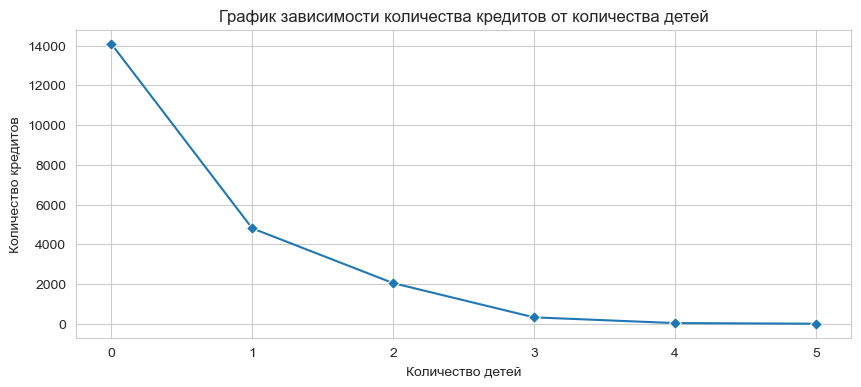

In [21]:
#Построим график
# применяем стиль whitegrid из библиотеки seaborn
sns.set_style('whitegrid')
# назначаем размер графика
plt.figure(figsize=(10, 4))
# строим линейный график средствами seaborn
sns.lineplot(x='children', y='count', data=chil_debt, marker='D')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('График зависимости количества кредитов от количества детей')
plt.xlabel('Количество детей')
plt.ylabel('Количество кредитов')
# отображаем график на экране
plt.show()

Исходя из данных мы видим, что заемщики без детей возвращают кредит чаще, чем с детьми. А вот какое именно количество детей в семье - практически не влияет на задолженности. Также мы видим, что данных о семьях с 5-ю детьми нет - это означает, что их слишком мало, чтобы иметь возможность сделать выводы. Значит наша выборка не сбалансирована, классы в выборке имеют разные размеры.

#### Зависимость между семейным положением и возвратом кредита в срок

In [22]:
#Сгруппируем данные по семейному положению и определим кол-во задолжностей соответственно 
fam_debt = data.groupby('family_status')['debt'].agg(['count','sum'])
#Создадим новый столбец. Определим отношение семейного статуса к доле невозврата кредита
fam_debt['dependence,%'] = (fam_debt['sum']/fam_debt['count'])*100
#Отсортируем данные от более надежных заемщиков к наименее
fam_debt.sort_values(by=['dependence,%'], ascending=True)

,count,sum,"dependence,%"
family_status,,,
вдовец / вдова,951,63,6.624606
в разводе,1189,84,7.064760
женат / замужем,12261,927,7.560558
гражданский брак,4134,385,9.313014
Не женат / не замужем,2796,273,9.763948


На данный вопрос данные не дают однозначного ответа. Зависимость между семейным положением и возвратом кредита в срок есть, но разница не большая. 

Однако появляется вопрос: а чем отличается человек в разводе от человека не в браке? Данных чтобы ответить на этот вопрос я не нашла. Зато вижу у них общее - отсутствие отношений. Исходя из этого я сделала дополнительное исследование. 

#### Дополнительное исследование: зависимость между семейным положением и возвратом кредита в срок

In [23]:
#Разделим все статусы на две категории: в паре - замужем, гражданский брак и одинокие - 
#овдовевшие, в разводе, не в браке.
def categorize_family_status(row):
    try:
        if 'женат / замужем' in row or 'граждан' in row:
            return 'в паре'
        elif 'вдов' in row or 'в разводе' in row or 'Не женат / не замужем' in row:
            return 'одинокие'
    except:
        return 'нет категории'

In [24]:
#Добавим новый столбец
data['family_category'] = data['family_status'].apply(categorize_family_status)

In [25]:
#Сгруппируем данные по семейному положению и определим кол-во задолжностей соответственно
fam2_debt = data.groupby('family_category')['debt'].agg(['count','sum'])
#Создадим новый столбец. Определим отношение семейного статуса к доле невозврата кредита
fam2_debt['dependence,%'] = (fam2_debt['sum']/fam2_debt['count'])*100
fam2_debt.sort_values(by=['dependence,%'], ascending=True)

,count,sum,"dependence,%"
family_category,,,
в паре,16395,1312,8.002440
одинокие,4936,420,8.508914


<b>Вывод:</b> для проработки гипотезы о влиянии семейного положения на возврат кредита я провела два исследования. 
       <br/> - первое: изучение данных среди заданных значений в категории по умолчанию. Однако результат меня не удовлетворил. Считаю неверным определять, что например вдовцы/вдовы возвращают кредиты чаще, чем люди вне брака - ведь и те и другие находятся вне отношений. Обозначает ли тот или иной статус действительно наличие или отсутствие отношений у оных? Быть может человек женатый не проживает с супругой совместно и не ведет общий бюджет, но брак еще зарегистрирован - как верно определить это? Потому я делаю вывод, что семейное положение не влияет на возврат кредита.
       <br/> - второе: решено было подтвердить мой вывод и сгруппировать семейное положение в две категории. <br/>1 - одинок (вдовы/вдовцы, в разводе и не женат/ не замужем). <br/>2 - в паре (гражданский брак, замужем/женат). По результату разница настолько мала, что первоначальный вывод подтверждается - семейное положение не влияет.

#### Зависимость между уровнем дохода и возвратом кредита в срок

In [26]:
#Сгруппируем данные по классификатору дохода и определим кол-во задолжностей соответственно
income_debt = data.groupby('total_income_category')['debt'].agg(['count','sum'])
#Создадим новый столбец. Определим отношение дохода к доле невозврата кредита
income_debt['dependence,%'] = (income_debt['sum']/income_debt['count'])*100
#Отсортируем данные от более надежных заемщиков к наименее
income_debt.sort_values(by=['dependence,%'], ascending=True)

,count,sum,"dependence,%"
total_income_category,,,
D,349,21,6.017192
B,5013,354,7.061640
A,25,2,8.000000
C,13831,1183,8.553250
E,22,2,9.090909


Мы видим, что заемщики с доходами меньше 30 000 и больше 1 млн реже возвращают кредит вовремя. Но также мы видим, что выборка очень мала: 22 и 25 заемщиков соответственно. Из-за малого размера выборки выводы делать некорректно. 

Если говорит о заемщиках категории С, B, D - однозначной закономерности нет, потому мы не можем утверждать, что "те, кто получаются больше зарплату, лучше отдают кредит".  

#### Влияние целей кредита на его возврат в срок

In [27]:
#Сгруппируем данные по классификатору цели кредита и определим кол-во задолжностей соответственно 
purpose_debt = data.groupby('purpose_category')['debt'].agg(['count','sum'])
#Создадим новый столбец. Определим при какой цели кредита чаще возвращают вовремя
purpose_debt['dependence,%'] = (purpose_debt['sum']/purpose_debt['count'])*100
#Отсортируем данные от более надежных заемщиков к наименее
purpose_debt.sort_values(by=['dependence,%'], ascending=True)

,count,sum,"dependence,%"
purpose_category,,,
операции с недвижимостью,10751,780,7.255139
проведение свадьбы,2313,183,7.911803
получение образования,3988,369,9.252758
операции с автомобилем,4279,400,9.347978


Кредиты с целью получения образования и операции с автомобилем чаще попадают в просрочку. В то время как кредиты на покупка/операции жилья и проведение свадьбы - чаще погашают во время.

## Вывод

Мы провели исследования о взаимосвязи семейного положение, дохода, целей кредита и количества детей на своевременный возврат кредита банку.

**Влияние дохода на возврат кредита.**

Мы разделили доход на 5-ть категории:
- 0–30 000
- 30 001–50 000
- 50 001–200 000
- 200 001–1 000 000
- 1 000 001 и выше

Реже всех возвращают кредит заемщики с доходами менее 30 000 - 9%.
Клиенты с доходами от 30 000 - 50 000 и 200 000 - 1 000 000руб возвращают кредиты чаще - 6% и 7% соответственно и являются более добросовестными плательщиками.
Так как категория дохода 50 000 - 200 000 руб показывает серединный результат  - 8%, рекомендую более глубоко изучить влияние дохода совместно с другими параметрами, а не изолировано, так как закономерности (чем выше доход, тем чаще возвращают кредит) установить не удалось.

**Влияние детей на возврат кредита.**

Однозначно заемщики без детей отдают кредиты чаще, чем с детьми - всего 7,5%. А вот какое именно количество детей не влияет, так как результаты очень близки: один ребенок - 9,2% просрочки, два - 9,4%.

Кредиторов с тремя детьми в данных в 6 раз меньше, чем, например, с одним - потому считаю базу не достаточной, чтобы сделать выводы, что семьи с тремя детьми возвращают кредит чуть чаще, чем с 1, 2 или 4 детьми.

**Влияние цели кредита на его возврат.**

Кредит отдают чаще при целях покупка/операции с недвижимостью и проведение свадьбы (7,2% и 7,9% соответственно). Кредиты с целью покупки авто и получение образования реже (9,3 и 9,2 соответственно).

**Влияение семейного положения на возврат кредита.**

В ходе исследования мы получили неоднозначные данные. Например, показатель невозвратов у овдовевших людей (6,6%) или людей в разводе(7%) близок к проценту невозврата у людей в браке (7,5%). Очевидно: это сравнение людей одиноких и людей в паре - и оно очень близко.

Поэтому мы проведи дополнительное исследование объединив такие значения как овдовевшие, в разводе, не в браке в "одинокие", а значения: в браке, гражданский брак - "в браке". При сравнении двух категорий значения близки - 8% и 8,5% - влияния не установлено.

**Подводя итог** однозначно можем сказать, что на возврат кредита влияет наличие детей (но не их количество) и цель кредита.